# 一、读取处理数据、计算因子、计算报告所需要的各类数据

# 申万指数数据

In [1]:
import pandas as pd
from datetime import datetime
index_ = pd.read_excel("/home/aq/下载/202106/data/1.xlsx")
index_ = index_.set_index("日期")
index_.columns = [x.split(")")[-1] for x in index_.columns]
index_ = index_.unstack()
index_ = index_/100
index_ = pd.DataFrame(index_,columns=["index_pct"])
index_

index_pct
          日期                   
801010.SI 2008-01-02   0.043001
          2008-01-03   0.023413
          2008-01-04   0.015018
          2008-01-07   0.035388
          2008-01-08  -0.028943
...                         ...
801890.SI 2021-06-07   0.004929
          2021-06-08  -0.005008
          2021-06-09   0.001697
          2021-06-10   0.003531
          2021-06-11  -0.007269

[91560 rows x 1 columns]

# 日度交易数据

In [2]:
import pickle
file = "/home/aq/下载/202106/data/"
df = pd.read_csv(file+"day_data.csv")
df = df.set_index(["code","date"])

In [3]:
df["pctChg"] = df["pctChg"] / 100
df["turn"] = df["turn"] / 100
df["mv"] = df["amount"] / df["turn"]

# 行业数据

In [4]:

import tushare as ts
pro = ts.pro_api("eb13b3bfd2bd07fd9eb40234f19941c73f230e1e98cc212b8cd407c7")
industry = pro.index_classify(level='L1', src='SW')
industry = list(industry["index_code"])

ind_df = pd.DataFrame()
for i in industry:
    temp = pd.DataFrame(list(pro.index_member(index_code=i)["con_code"]),columns=["code"])
    temp["sw"] = i
    ind_df = pd.concat([ind_df,temp])

def codefun(x):
    f,b = x.split(".")
    return b.lower()+"."+f

ind_df["code"] = ind_df["code"].apply(lambda x:codefun(x))
ind_dic = {x:y for (x,y) in zip(ind_df["code"],ind_df["sw"])}

# 全A指数数据

In [5]:
file = "/home/aq/下载/202106/data/"
wma = pd.read_excel(file+"Wind市场指数(日).xls")
wma = wma[4:]
wma.columns = ["date","mr"]
wma["date"] = wma["date"].apply(lambda x:datetime.strftime(x,"%Y-%m-%d"))
wma = wma.set_index(["date"])
mr = wma.copy()
mr["mr"] = mr["mr"] / mr["mr"].shift(1) - 1

# 计算因子P

In [9]:
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn import linear_model
result = []
for c in tqdm(list(ind_dic.keys())):
    temp = df.loc[(c,slice(None)),:]  #个股数据
    temp["price"] = (temp["close"].shift(-1) + temp["close"]) / 2
    temp["month"] = [x[1] for x in temp.index.tolist()]
    temp["month"] = temp["month"].apply(lambda x:x[:-3])

    for g in temp.groupby(temp["month"]):
        month = g[1].copy()
        lnmv = np.log(list(month["mv"])[-1])
        vol = month["pctChg"].std()
        rev = list(month["close"])[-1] / list(month["close"])[0]
        tr = month["turn"].mean()
        ts = list(month["tradestatus"])[-1]
        isst = list(month["isST"])[-1]
        price = list(month["price"])[-1]
        close = list(month["close"])[-1]
        sdate = [x[1] for x in month.index.tolist()]
        
        temp_mr = list(mr.loc[sdate,"mr"])
        temp_ind = list(index_.loc[(ind_dic[c],sdate),"index_pct"])
        indcode = ind_dic[c]
        rdf = []
        rdf.append(list(month["pctChg"]))
        rdf.append(temp_mr)
        rdf.append(temp_ind)
        rdf = pd.DataFrame(rdf)
        rdf = rdf.T
        rdf = rdf.dropna(how="any",axis=0)
        y = rdf.iloc[:,0].values.reshape(-1,1)
        x = rdf.iloc[:,1:].values
        
        lr = linear_model.LinearRegression()
        lr.fit(x,y)
        r2 = lr.score(x,y)
        try:
            P = np.log(r2/(1-r2))
        except:  #防止有些个别股票某些个别月份交易日非常短，或者股价波动异常，导致拟合度为负或异常
            P = np.nan
        date = sdate[-1]
        gr = [c,date,close,r2,indcode,P,lnmv,vol,rev,tr,price,isst,ts]
        result.append(gr)
        
pdata = pd.DataFrame(result,columns=["code","date","close","r-squared","sw","P","lnmv","vol",
                                    "rev","tr","price","isST","tradestatus"])
pdata = pdata.set_index(["code","date"])

100%|██████████| 3735/3735 [1:13:57<00:00,  1.19s/it]


In [10]:
pickle.dump(pdata,open(file+"pdata","wb"))

In [7]:
pdata["last_trade_date"] = [x[1] for x in pdata.index.tolist()]
pdata["code"] = [x[0] for x in pdata.index.tolist()]
def date_2_last(x):
    t = x.split("-")
    any_day = datetime(int(t[0]),int(t[1]),int(t[2]))

    def last_day_of_month(any_day):
        from datetime import timedelta
        next_month = any_day.replace(day=28) + timedelta(days=4)  # this will never fail
        return next_month - timedelta(days=next_month.day)
    
    return datetime.strftime(last_day_of_month(any_day),"%Y-%m-%d")

pdata["date"] = pdata["last_trade_date"].apply(lambda x:date_2_last(x))
pdata = pdata.set_index(["code","date"])

In [8]:
pdata = pdata.query('isST==0 & tradestatus==1')
pdata = pdata.drop(labels=["isST","tradestatus"],axis=1)
pdata["P"] = pdata["P"].replace(np.inf,np.nan)
pdata = pdata.dropna(subset=["P"],axis=0)

In [9]:
print(pdata.shape)
pdata.describe().T

(373171, 10)


,count,mean,std,min,25%,50%,75%,max
close,373171.0,124.613395,1737.643393,0.740393,18.129532,32.353888,59.688679,201067.359014
r-squared,373171.0,0.496176,0.240267,0.000001,0.309092,0.511173,0.690830,1.000000
P,373171.0,-0.074726,1.317079,-13.720669,-0.804368,0.044699,0.804002,14.675087
lnmv,373171.0,22.108597,1.177049,18.060988,21.330056,22.018021,22.757973,28.540799
vol,373171.0,0.028447,0.018570,0.000038,0.018551,0.025376,0.034810,2.675779
rev,373171.0,1.010178,0.169633,0.198602,0.926635,0.995106,1.072773,14.407895
tr,373171.0,0.029795,0.036285,0.000033,0.009158,0.018307,0.036493,0.622732
price,369651.0,124.954835,1743.209525,0.753614,18.155585,32.388585,59.746301,191006.779178


# 计算个股return

In [10]:
codelist = [x[0] for x in pdata.index.tolist()]
codelist = list(set(codelist))
return_df = []
for c in tqdm(codelist):
    temp = pdata.loc[(c,slice(None)),:]
    temp["code"] = [x[0] for x in temp.index.tolist()]
    temp["date"] = [x[1] for x in temp.index.tolist()]
    temp["return"] = temp["price"].shift(-1) / temp["price"] - 1
    r = temp.loc[:,["code","date","return"]].values.tolist()
    return_df.extend(r)

100%|██████████| 3734/3734 [00:17<00:00, 214.74it/s]


In [11]:
return_df = pd.DataFrame(return_df,columns=["code","date","return"])
return_df = return_df.set_index(["code","date"])
pdata["return"] = return_df["return"]

In [12]:
pdata

close  r-squared         sw         P       lnmv  \
code      date                                                               
sh.600348 2008-01-31  59.279431   0.701411  801020.SI  0.854024  23.110829   
          2008-02-29  51.711376   0.874601  801020.SI  1.942270  22.951981   
          2008-03-31  38.027277   0.643325  801020.SI  0.589825  22.683322   
          2008-04-30  47.839348   0.664867  801020.SI  0.685062  22.869547   
          2008-05-31  51.810377   0.808695  801020.SI  1.441551  22.979574   
...                         ...        ...        ...       ...        ...   
sh.603183 2020-08-31  25.263075   0.116320  801230.SI -2.027745  20.990535   
          2020-09-30  23.518854   0.531761  801230.SI  0.127216  21.440661   
          2020-10-31  23.687649   0.736536  801230.SI  1.028039  21.458583   
          2020-11-30  25.825727   0.008282  801230.SI -4.785350  21.547984   
          2020-12-31  21.774632   0.234925  801230.SI -1.180708  21.378772   

                           vol       rev        tr      price last_trade_date  \
code      date                                                                  
sh.600348 2008-01-31  0.055508  1.020064  0.021486  59.246431      2008-01-31   
          2008-02-29  0.039847  0.873305  0.010390  51.991878      2008-02-29   
          2008-03-31  0.041284  0.727483  0.016744  36.360764      2008-03-31   
          2008-04-30  0.057465  1.378884  0.023284  48.290351      2008-04-30   
          2008-05-31  0.051554  1.062965  0.050435  52.112879      2008-05-30   
...                        ...       ...       ...        ...             ...   
sh.603183 2020-08-31  0.040876  1.108642  0.093785  25.431870      2020-08-31   
          2020-09-30  0.022861  0.918681  0.055402  24.306566      2020-09-30   
          2020-10-31  0.023826  0.943946  0.024384  23.828312      2020-10-30   
          2020-11-30  0.020087  1.077465  0.033943  25.769462      2020-11-30   
          2020-12-31  0.017365  0.846827  0.015360        NaN      2020-12-31   

                        return  
code      date                  
sh.600348 2008-01-31 -0.122447  
          2008-02-29 -0.300645  
          2008-03-31  0.328090  
          2008-04-30  0.079157  
          2008-05-31 -0.185208  
...                        ...  
sh.603183 2020-08-31 -0.044248  
          2020-09-30 -0.019676  
          2020-10-31  0.081464  
          2020-11-30       NaN  
          2020-12-31       NaN  

[373171 rows x 11 columns]

# 计算全A指数的月末值

In [13]:
index_ = wma.copy()
index_.index = [datetime.strptime(x,"%Y-%m-%d") for x in index_.index]
index_ = index_.resample("M").last()
index_.index = [datetime.strftime(x,"%Y-%m-%d") for x in index_.index]
index_

,mr
2008-01-31,3430.9375
2008-02-29,3548.4241
2008-03-31,2870.1191
2008-04-30,2946.6946
2008-05-31,2724.3125
...,...
2020-08-31,5322.2441
2020-09-30,5004.5431
2020-10-31,5057.2464
2020-11-30,5258.6579


# 计算分析所需要的各类数据，中性化

# 按时间截面计算

In [14]:
def pre_ohe(df,list_ohe,s):
    """
    做行业值的独热编码one-hot-encoding
    """
    for i in list_ohe:
        df[i] = df[i].apply(lambda x:str(x))
    df.index = range(df.shape[0])
    name_list = []
    o_sub = pd.DataFrame()
    for i in list_ohe:
        a = list(set(df[i]))
        a.sort()
        a = [str(x) for x in a]
        b = [i+s+x for x in a]
        name_list.append(b)
        df[i] = df[i].replace(a,range(len(a)))
        o_sub = pd.concat([o_sub,df[i]],axis=1)
    df = df.drop(labels=list_ohe,axis=1)

    from sklearn import preprocessing
    model = preprocessing.OneHotEncoder()
    values = model.fit_transform(o_sub.values).toarray()
    col_name = pd.Series(name_list).cumsum()
    col_name = col_name[len(col_name)-1]

    o_sub = pd.DataFrame(data=values,columns=col_name,index=df.index)

    return o_sub

def neutralization(xdf,y):
    """
    做行业中性化和市值中性化
    """
    x = xdf.values  
    from sklearn import linear_model
    lr = linear_model.LinearRegression()
    lr.fit(x,y)
    alpha = y - lr.predict(x)
    return alpha

In [15]:
from sklearn import preprocessing
import scipy.stats as ss
datelist = [x[1] for x in pdata.index.tolist()]
datelist = list(set(datelist))
datelist.sort()

qcut_num = 10  #分组数量10组

r2_stats = []  #拟合度分位数
mv_stats = []  #市值统计
ind_stats = [] #行业
ic_list = []   #IC
corr_list = []  #相关性
fac_stats = []  #与因子关系的统计
back_test = []

#中性化相关结果存储
neu_mv_stats = []
neu_ic_list = []
neu_back_test = []

for n in tqdm(range(len(datelist))):
    d = datelist[n]
    temp = pdata.loc[(slice(None),d),:]
    
    #计算中性化因子
    temp['code'] = [x[0] for x in temp.index.tolist()]
    temp['industry'] = temp['code'].apply(lambda x:ind_dic[x])
    xdf = temp.loc[:,['industry']]
    xdf = pre_ohe(xdf,["industry"],":")
    xdf['lnmv'] = list(temp['lnmv'])
    y = temp['P']
    neu_p = neutralization(xdf,y)
    temp['NEU_P'] = neu_p
    
    #拟合度相关结果
    des = temp["r-squared"].describe()
    r2s = list(des.loc[["25%","50%","75%"]])
    a = index_.loc[[d]].values.tolist()[0][0]
    r2s.append(a)      #拟合度分位数+wind全A

    #rank_ic相关结果
    temp = temp.sort_values(by="P",ascending=False)
    temp["rank_P"] = range(len(temp))
    temp = temp.sort_values(by="lnmv",ascending=False)
    temp["rank_mv"] = range(len(temp))
    temp = temp.sort_values(by="return",ascending=False)
    temp["rank_return"] = range(len(temp))
    rank_ic = ss.spearmanr(temp["rank_P"],temp["rank_return"])
    rank_ic_mv = ss.spearmanr(temp["rank_mv"],temp["rank_return"])[0]
    ics = [rank_ic[0],rank_ic[1],rank_ic_mv]

    #分组
    cut = pd.qcut(list(temp["rank_P"]),qcut_num)
    temp["qcut"] = cut.codes
    
    
    #中性化rank_ic相关结果
    temp = temp.sort_values(by="NEU_P",ascending=False)
    temp["rank_NEU_P"] = range(len(temp))
    temp = temp.sort_values(by="lnmv",ascending=False)
    temp["rank_mv"] = range(len(temp))
    temp = temp.sort_values(by="return",ascending=False)
    temp["rank_return"] = range(len(temp))
    rank_ic = ss.spearmanr(temp["rank_NEU_P"],temp["rank_return"])
    rank_ic_mv = ss.spearmanr(temp["rank_mv"],temp["rank_return"])[0]
    neu_ics = [rank_ic[0],rank_ic[1],rank_ic_mv]

    #中性化因子分组
    cut = pd.qcut(list(temp["rank_NEU_P"]),qcut_num)
    temp["neu_qcut"] = cut.codes
    
    
    
    #市值相关结果
    temp["mv"] = np.exp(temp["lnmv"])
    des_mv = temp["mv"].describe()
    mvs = list(des_mv.loc[["25%","50%","75%"]])
    g0mv = temp.query('qcut==0')
    g0mv = g0mv["mv"].mean()
    mvs.append(g0mv)

    gmv = temp["mv"].groupby([temp["qcut"]]).mean()
    gmv = list(gmv)
    mvs.append(gmv)
    
    
    #中性化市值相关结果
    temp["mv"] = np.exp(temp["lnmv"])
    des_mv = temp["mv"].describe()
    neu_mvs = list(des_mv.loc[["25%","50%","75%"]])
    g0mv = temp.query('neu_qcut==0')
    g0mv = g0mv["mv"].mean()
    neu_mvs.append(g0mv)

    gmv = temp["mv"].groupby([temp["neu_qcut"]]).mean()
    gmv = list(gmv)
    neu_mvs.append(gmv)

    
    #行业相关结果
    tmp = (temp["sw"].groupby(temp["sw"]).count())/ len(temp)
    g0mp = temp.query("qcut==0")
    g0mp = (g0mp["sw"].groupby(g0mp["sw"]).count())/ len(g0mp)
    sp = pd.concat([tmp,g0mp],axis=1)
    sp.columns = ["全市场行业权重","第一组行业权重"]

    #自相关
    try:
        temp0 = temp.copy()
        temp0.index = [x[0] for x in temp0.index.tolist()]
        temp1 = pdata.loc[(slice(None),datelist[n+1]),:]
        temp1.index = [x[0] for x in temp1.index.tolist()]
        cdf = pd.concat([temp0["P"],temp1["P"]],axis=1)
        cdf.columns = [0,1]
        cdf = cdf.dropna(how="any",axis=0)
        corr = ss.pearsonr(cdf[0],cdf[1])[0]
    except:
        corr = np.nan

    #其他因子统计
    fs = pd.DataFrame()
    for g in temp.groupby([temp["qcut"]]):
        gf = g[1].iloc[:,4:8].mean()
        fs = pd.concat([fs,gf],axis=1)
    fs = fs.T
    fs.index = range(len(fs))
    
    #回测相关数据
    ta_return = temp["return"].mean()
    group_return = temp["return"].groupby(temp["qcut"]).mean()
    rlist = [group_return,ta_return]
    
    #中性化回测相关数据
    ta_return = temp["return"].mean()
    group_return = temp["return"].groupby(temp["neu_qcut"]).mean()
    neu_rlist = [group_return,ta_return]
    
    
    #时间截面上的合并
    r2_stats.append(r2s)
    mv_stats.append(mvs)
    ind_stats.append(sp)
    ic_list.append(ics)
    corr_list.append(corr)
    fac_stats.append(fs)
    back_test.append(rlist)
    
    neu_mv_stats.append(neu_mvs)
    neu_ic_list.append(neu_ics)
    neu_back_test.append(neu_rlist)

100%|██████████| 156/156 [00:16<00:00,  9.65it/s]


# 二、绘图和结果

In [16]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['simhei']
plt.rcParams['axes.unicode_minus'] = False 

# 个股与指数例子

In [17]:
def plot1(code):
    close = pdata.loc[(code,slice(None)),"close"]
    rsquared = pdata.loc[(code,slice(None)),"r-squared"]
    xdate = [datetime.strptime(x[1],"%Y-%m-%d") for x in close.index.tolist()]

    fig = plt.figure(figsize=(20,8))
    ax = plt.subplot(111)
    l1, = ax.plot(xdate,close,"b--",alpha=0.4)
    ax.fill_between(xdate,0,close,facecolor='blue', alpha=0.4)

    ax.set_xlabel("date",fontsize=20)
    ax.set_ylabel("stock price",fontsize=20)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    ax1 = ax.twinx()
    l2, = ax1.plot(xdate,rsquared,"r",alpha=0.6)
    ax1.set_ylabel("r-squared",fontsize=20)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.grid(True)
    plt.legend([l1,l2],[code,"R-squared"],loc="lower left",fontsize=20)
    return


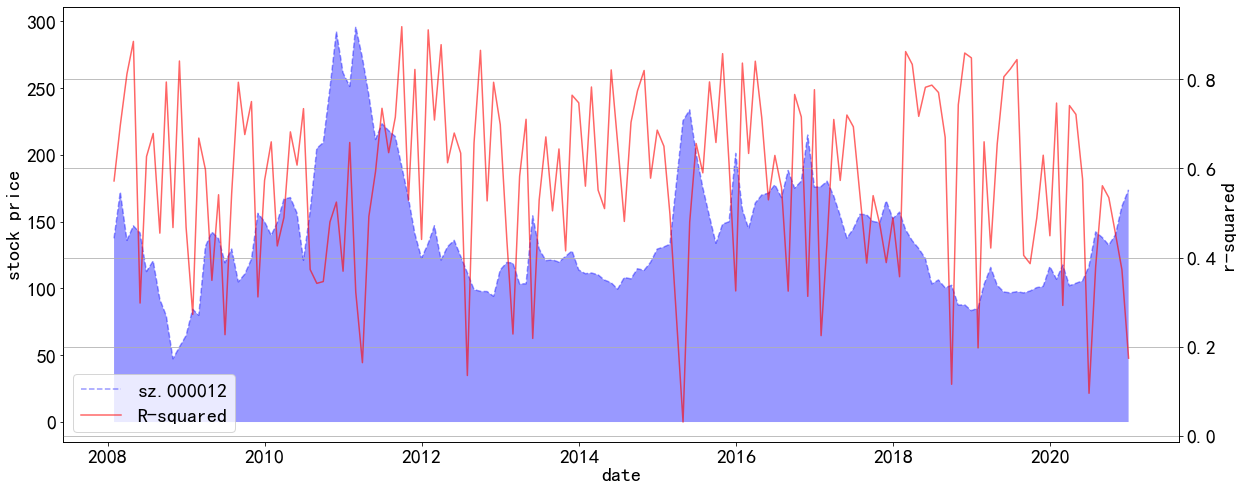

In [18]:
code = "sz.000012"
plot1(code)

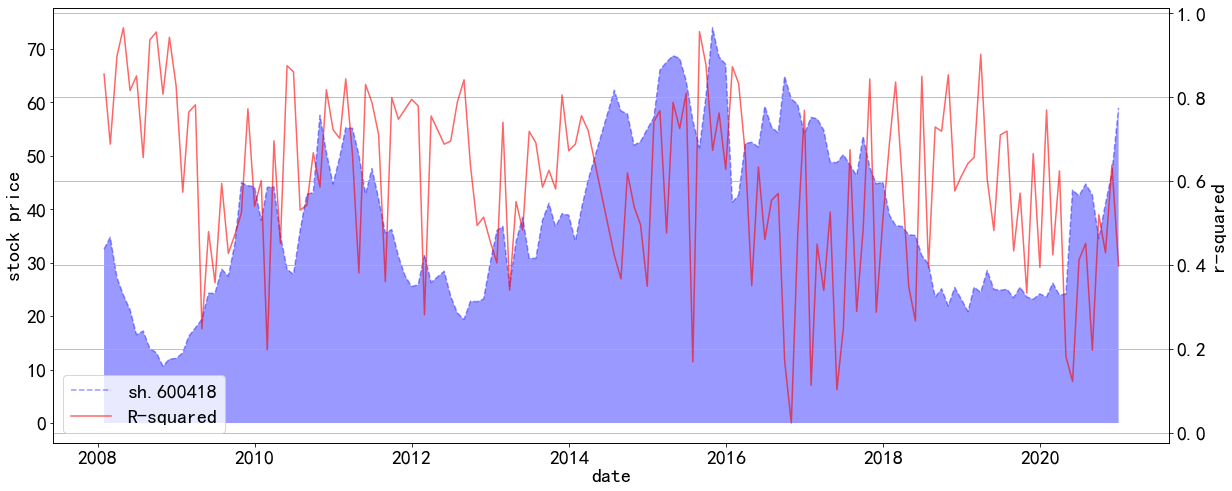

In [19]:
code = "sh.600418"
plot1(code)

In [20]:
r2_stats = pd.DataFrame(r2_stats,columns=["25%","50%","75%","Index"])
r2_stats.index = datelist

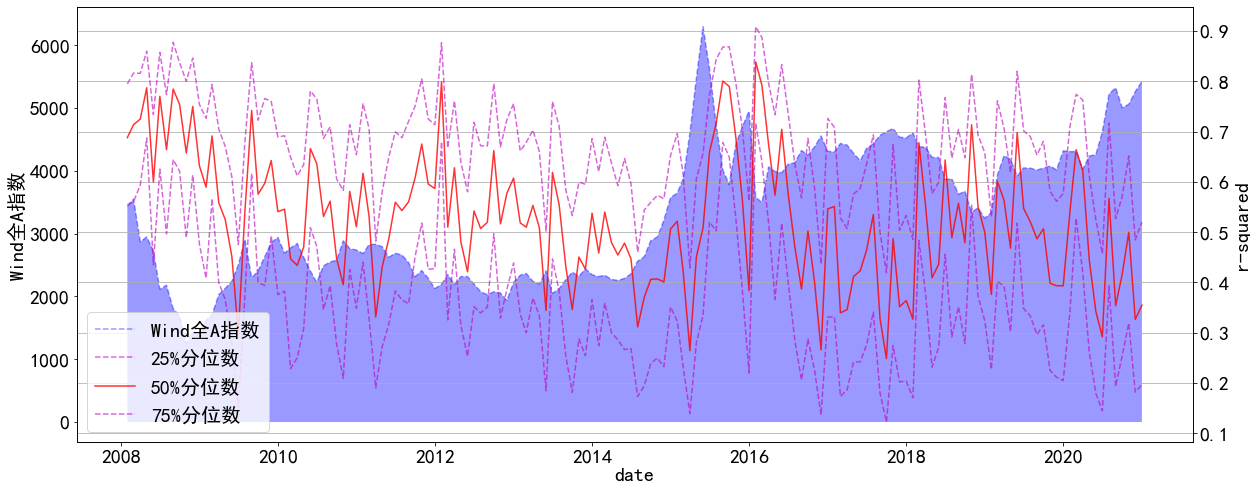

In [21]:
index = r2_stats.loc[:,"Index"]
l25 = r2_stats.loc[:,"25%"]
l50 = r2_stats.loc[:,"50%"]
l75 = r2_stats.loc[:,"75%"]
xdate = [datetime.strptime(x,"%Y-%m-%d") for x in r2_stats.index.tolist()]

fig = plt.figure(figsize=(20,8))
ax = plt.subplot(111)
l1, = ax.plot(xdate,index,"b--",alpha=0.4)
ax.fill_between(xdate,0,index,facecolor='blue', alpha=0.4)

ax.set_xlabel("date",fontsize=20)
ax.set_ylabel("Wind全A指数",fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax1 = ax.twinx()
l25, = ax1.plot(xdate,l25,"m--",alpha=0.6)
l50, = ax1.plot(xdate,l50,"r",alpha=0.8)
l75, = ax1.plot(xdate,l75,"m--",alpha=0.6)

ax1.set_ylabel("r-squared",fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(True)
plt.legend([l1,l25,l50,l75],["Wind全A指数","25%分位数","50%分位数","75%分位数"],fontsize=20)

# P与其他因子关系

In [22]:
cdf = pdata.loc[:,["P","lnmv",'vol','rev','tr']].corr()
cdf

,P,lnmv,vol,rev,tr
P,1.000000,0.095425,-0.001077,-0.214891,-0.192632
lnmv,0.095425,1.000000,-0.126190,0.037728,-0.298784
vol,-0.001077,-0.126190,1.000000,0.196703,0.477353
rev,-0.214891,0.037728,0.196703,1.000000,0.188178
tr,-0.192632,-0.298784,0.477353,0.188178,1.000000


(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

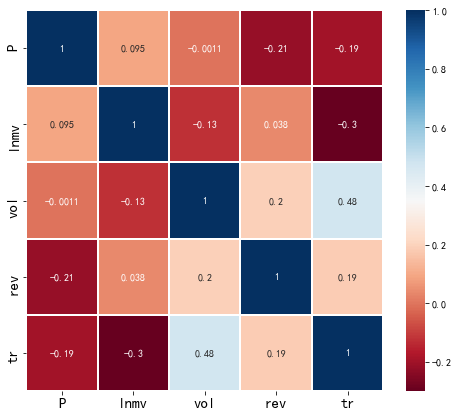

In [23]:
import seaborn as sns
fig = plt.figure(figsize=(8,7))
sns.heatmap(cdf,cmap="RdBu",annot=True,linewidths=1)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# 组合回测

由于没有加入2021年1月和2月的数据，因此实际回测2020年11月和12月的组合收益是没有的。即实际最后是2020年12月1日卖出。

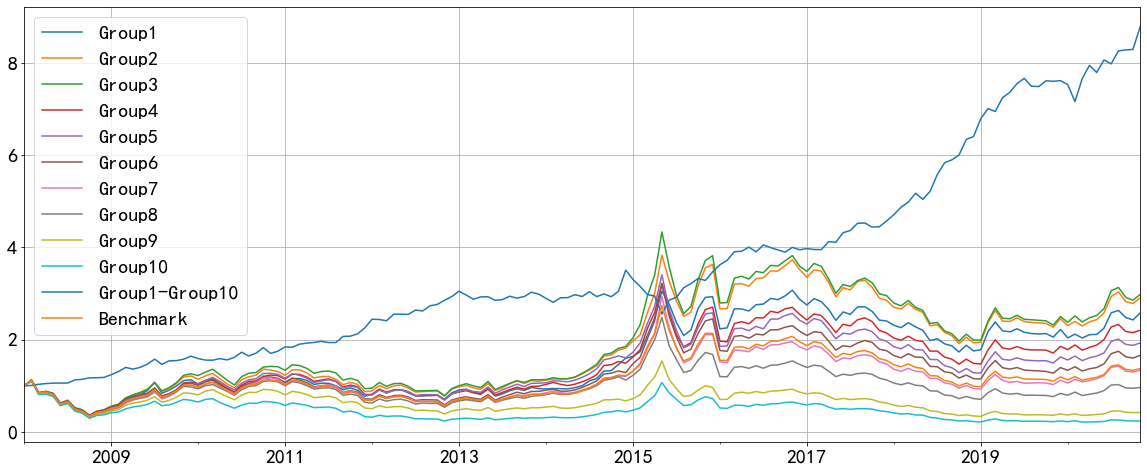

In [24]:
cost0 = 0.003 #买入时交易成本
cost1 = 0.003 #卖出时交易成本
#全市场等权组合
benchmark = [((1-cost0)*(x[1]+1)*(1-cost1)-1) for x in back_test]
benchmark = pd.DataFrame(benchmark,index=datelist)

group_return = pd.DataFrame()
for i in back_test:
    group_return = pd.concat([group_return,i[0]],axis=1)
group_return.columns = datelist
group_return.index = ["Group"+str(i+1) for i in group_return.index]
group_return = group_return.T
def costfun(x):
    return (1-cost0)*(x+1)*(1-cost1)-1
group_return = group_return.applymap(lambda x:costfun(x))

group_return["Group1-Group10"] = group_return["Group1"] - group_return["Group10"]
group_return["Benchmark"] = benchmark
group_return = group_return.shift(1)
group_return = group_return[0:-1]
group_return = group_return.fillna(0)

xdate = [datetime.strptime(x,"%Y-%m-%d") for x in group_return.index]

return_plot1 = group_return + 1
return_plot1.index = xdate
return_plot1 = return_plot1.cumprod()
return_plot1.plot(figsize=(20,8),fontsize=20,grid=True)
plt.legend(fontsize=20)

In [25]:
last = return_plot1.iloc[len(return_plot1)-1,:]
year_r = (last[:10] - 1)*(252 / ((2020-2008+1)*252 - 22))
excess_r = (last[:10] - last["Benchmark"])*(252 / ((2020-2008+1)*252 - 22))
year_r.name = "年化收益"
excess_r.name = "超额年化"

In [26]:
def cal_ir(x,y):
    lr = linear_model.LinearRegression()
    lr.fit(x,y)
    extra_return = y - x
    red_error = lr.predict(x) - y
    re_std = red_error.std()
    information_ratio = extra_return.mean() / re_std
    information_ratio = information_ratio*(12**(1/2))
    return information_ratio



In [27]:
gr = group_return.iloc[:,:10].copy()
pr1 = []
for i in gr.columns:
    gr[i] = gr[i] - group_return["Benchmark"]
    winp = list(gr[i]>0).count(True) / len(gr)
    pcr = gr[gr[i]>0][i].mean() / abs(gr[gr[i]<=0][i].mean())
    
    y = group_return[i].values.reshape(-1,1)
    x = group_return["Benchmark"].values.reshape(-1,1)
    information_ratio = cal_ir(x,y)
    pr1.append([winp,pcr,information_ratio])
    
pr1 = pd.DataFrame(pr1,index=year_r.index,columns=["超额胜率","超额盈亏比","信息比率"])

pdf1 = pd.concat([year_r,excess_r,pr1],axis=1)
pdf1

,年化收益,超额年化,超额胜率,超额盈亏比,信息比率
Group1,0.122451,0.093454,0.574194,1.138405,0.551218
Group2,0.147709,0.118712,0.625806,1.638500,1.311607
Group3,0.153401,0.124404,0.690323,1.948973,1.889285
Group4,0.093217,0.064220,0.638710,1.302720,1.059666
Group5,0.071892,0.042895,0.593548,1.264840,0.786344
Group6,0.051221,0.022224,0.529032,1.411430,0.548212
Group7,0.025658,-0.003339,0.516129,0.974625,0.048458
Group8,-0.002764,-0.031761,0.458065,0.693278,-0.665630
Group9,-0.044798,-0.073795,0.270968,0.533914,-2.009661
Group10,-0.059073,-0.088070,0.238710,0.593557,-2.174833


In [28]:
#获取同期300和500数据
e_index = pd.read_excel(file+"e_index.xls")
e_index = e_index.set_index(["date"])
e_index.index = [datetime.strftime(x,"%Y-%m-%d") for x in e_index.index]
e_index = e_index.shift(1)
e_index = e_index.fillna(0)

group_return["sh.000300"] = e_index["sh.000300"]
group_return["sh.000905"] = e_index["sh.000905"]
adf = []
odf = []

for i in range(2020-2008+1):
    temp = group_return.iloc[i*12:(i+1)*12,:]
    
    cptemp = temp["Group1"]+1
    cptemp = cptemp.cumprod()
    yr = list(cptemp)[-1] - 1

    maxdrawdown = cptemp / cptemp.cummax() - 1
    maxdrawdown = abs(maxdrawdown.min())
    abs_winp = list(temp["Group1"]>0).count(True) / len(temp)
    adf.append([i+2008,yr,maxdrawdown,abs_winp])
    
    for bm in ["Benchmark","sh.000300","sh.000905"]:
        otemp = temp["Group1"] - temp[bm]
        cpo = otemp + 1
        cpo = cpo.cumprod()
        oyr = list(cpo)[-1] - 1
        
        omaxdrawdown = cpo / cpo.cummax() - 1
        omaxdrawdown = abs(omaxdrawdown.min())
        opo_winp = list(otemp>0).count(True) / len(otemp)
        
        x = temp[bm].values.reshape(-1,1)
        y = temp["Group1"].values.reshape(-1,1)
        
        ir = cal_ir(x,y)
        
        odf.append([i+2008,bm,oyr,omaxdrawdown,opo_winp,ir])

adf = pd.DataFrame(adf,columns=["年份","年度收益","最大回撤","绝对胜率"])
adf

,年份,年度收益,最大回撤,绝对胜率
0,2008,-0.543083,0.672505,0.416667
1,2009,1.476381,0.217189,0.916667
2,2010,-0.024928,0.254558,0.500000
3,2011,-0.297915,0.331940,0.250000
4,2012,0.094465,0.222761,0.583333
5,2013,0.107702,0.169016,0.583333
6,2014,0.699752,0.008601,0.750000
7,2015,0.836014,0.315666,0.750000
8,2016,-0.018140,0.063436,0.583333
9,2017,-0.164053,0.167896,0.333333


In [29]:
odf = pd.DataFrame(odf,columns=["年份","基准","相对年度收益","相对最大回撤","相对胜率","信息比率"])
odf["基准"] = odf["基准"].replace(["Benchmark"],["全市场等权"])
odf.query('基准=="全市场等权"')

,年份,基准,相对年度收益,相对最大回撤,相对胜率,信息比率
0,2008,全市场等权,0.008444,0.049855,0.583333,0.271366
3,2009,全市场等权,0.095920,0.054051,0.666667,1.225062
6,2010,全市场等权,-0.088409,0.074319,0.416667,-0.807807
9,2011,全市场等权,0.103891,0.024789,0.583333,2.143802
12,2012,全市场等权,0.118510,0.023679,0.583333,1.605068
15,2013,全市场等权,-0.073223,0.086094,0.416667,-1.465123
18,2014,全市场等权,0.127020,0.029166,0.583333,1.033605
21,2015,全市场等权,-0.016392,0.121052,0.583333,-0.040711
24,2016,全市场等权,0.059257,0.019274,0.416667,1.567954
27,2017,全市场等权,0.053526,0.019616,0.583333,1.422662


In [30]:
odf.query('基准=="sh.000300"')

,年份,基准,相对年度收益,相对最大回撤,相对胜率,信息比率
1,2008,sh.000300,0.202546,0.087801,0.500000,1.317384
4,2009,sh.000300,0.271237,0.041584,0.833333,2.730918
7,2010,sh.000300,0.124129,0.033319,0.583333,1.515347
10,2011,sh.000300,-0.056500,0.074776,0.500000,-0.639494
13,2012,sh.000300,0.026498,0.060654,0.416667,0.311324
16,2013,sh.000300,0.210275,0.024843,0.666667,2.413643
19,2014,sh.000300,0.076356,0.196382,0.666667,0.762571
22,2015,sh.000300,0.766412,0.042398,0.750000,2.604591
25,2016,sh.000300,0.119109,0.020427,0.666667,1.346243
28,2017,sh.000300,-0.317062,0.290120,0.250000,-2.317797


In [31]:
odf.query('基准=="sh.000905"')

,年份,基准,相对年度收益,相对最大回撤,相对胜率,信息比率
2,2008,sh.000905,0.100701,0.038963,0.500000,1.200965
5,2009,sh.000905,0.093539,0.070864,0.583333,0.944928
8,2010,sh.000905,-0.109562,0.095612,0.500000,-0.640893
11,2011,sh.000905,0.050102,0.025433,0.500000,1.032406
14,2012,sh.000905,0.095868,0.023457,0.750000,1.849757
17,2013,sh.000905,-0.050318,0.080572,0.416667,-1.096055
20,2014,sh.000905,0.230811,0.013813,0.750000,2.370241
23,2015,sh.000905,0.286824,0.024498,0.583333,1.802194
26,2016,sh.000905,0.180115,0.014548,0.750000,2.818565
29,2017,sh.000905,-0.157624,0.137050,0.250000,-2.416597


# 市值分布

(array([  0.,  50., 100., 150., 200., 250., 300.]),
 <a list of 7 Text major ticklabel objects>)

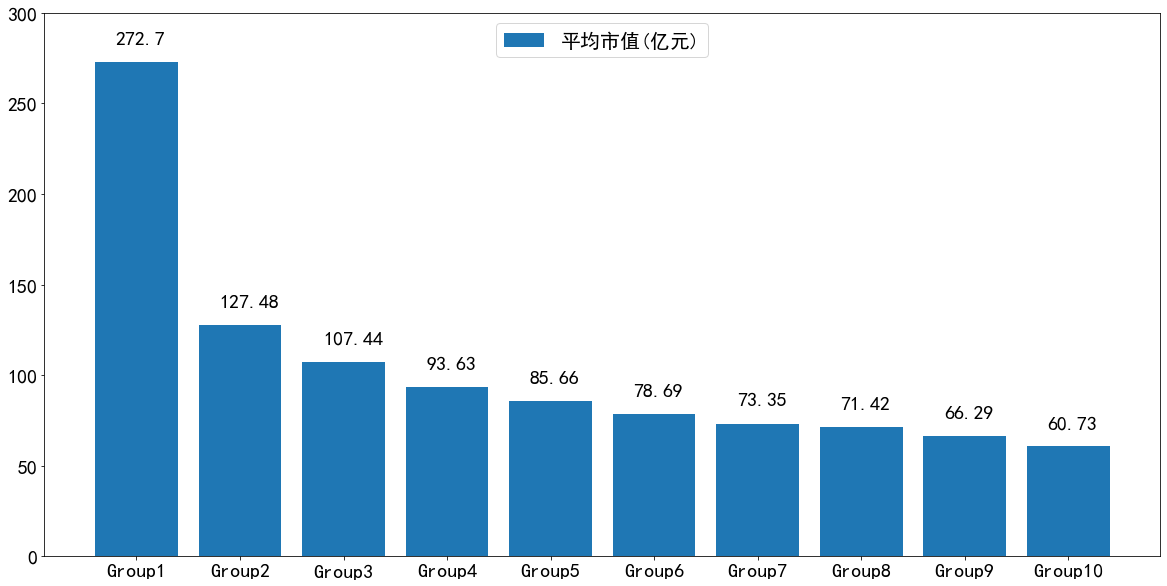

In [32]:
mv_plot1 = []
for i in mv_stats:
    mv_plot1.append(i[4])
mv_plot1 = pd.DataFrame(mv_plot1)
mv_plot1 = mv_plot1.mean(axis=0)
mv_plot1 = mv_plot1 / 1e+8
mv_plot1.index = ["Group"+str(x) for x in range(1,11)]
mv_plot1 = mv_plot1.apply(lambda x:round(x,2))

fig = plt.figure(figsize=(20,10))
b = plt.bar(mv_plot1.index,mv_plot1.values)
plt.legend([b],["平均市值(亿元)"],loc="upper center",fontsize=20)
for i in range(len(mv_plot1.index)):
    plt.text(i-0.2,mv_plot1[i]+10,mv_plot1[i],fontsize=20)
    
plt.ylim(0,300)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

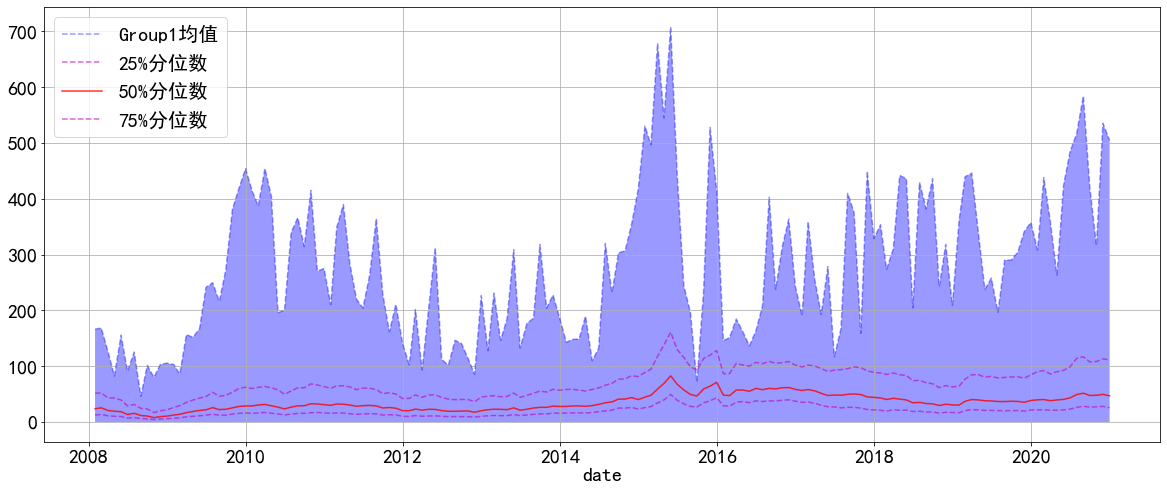

In [33]:
mv_plot2 = []
for i in mv_stats:
    mv_plot2.append(i[:4])
mv_plot2 = pd.DataFrame(mv_plot2,columns=["25%","50%","75%","Group1均值"],index=datelist)
mv_plot2 = mv_plot2/1e+8

index = mv_plot2.loc[:,"Group1均值"]
l25 = mv_plot2.loc[:,"25%"]
l50 = mv_plot2.loc[:,"50%"]
l75 = mv_plot2.loc[:,"75%"]
xdate = [datetime.strptime(x,"%Y-%m-%d") for x in mv_plot2.index.tolist()]

fig = plt.figure(figsize=(20,8))
ax = plt.subplot(111)
l1, = ax.plot(xdate,index,"b--",alpha=0.4)
ax.fill_between(xdate,0,index,facecolor='blue', alpha=0.4)

ax.set_xlabel("date",fontsize=20)

l25, = ax.plot(xdate,l25,"m--",alpha=0.6)
l50, = ax.plot(xdate,l50,"r",alpha=0.8)
l75, = ax.plot(xdate,l75,"m--",alpha=0.6)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(True)
plt.legend([l1,l25,l50,l75],["Group1均值","25%分位数","50%分位数","75%分位数"],fontsize=20)

# 行业分布

In [34]:
industry = pro.index_classify(level='L1', src='SW')
industry_dic = {x:y for (x,y) in zip(industry["index_code"],industry["industry_name"])}

In [35]:
ind_plot = pd.DataFrame()
for i in ind_stats:
    i = i.fillna(0)
    i = i.unstack()
    ind_plot = pd.concat([ind_plot,i],axis=1)
ind_plot = pd.DataFrame(ind_plot.mean(axis=1))
ind_plot["index"] = ind_plot.index
ind_plot["col"] = ind_plot["index"].apply(lambda x:x[0])
ind_plot["industry"] = ind_plot["index"].apply(lambda x:x[1])
ind_plot["industry"] = ind_plot["industry"].apply(lambda x:industry_dic[x])
ind_plot = ind_plot.set_index(["col","industry"])
ind_plot = ind_plot.drop(labels=["index"],axis=1)

ind_plot = ind_plot[0].unstack()
ind_plot.columns.name = ""
ind_plot.index.name = ""

ind_plot = ind_plot.T
ind_plot["DIFF"] = ind_plot["第一组行业权重"] - ind_plot["全市场行业权重"]
ind_plot = ind_plot.sort_values(by="DIFF",ascending=False)

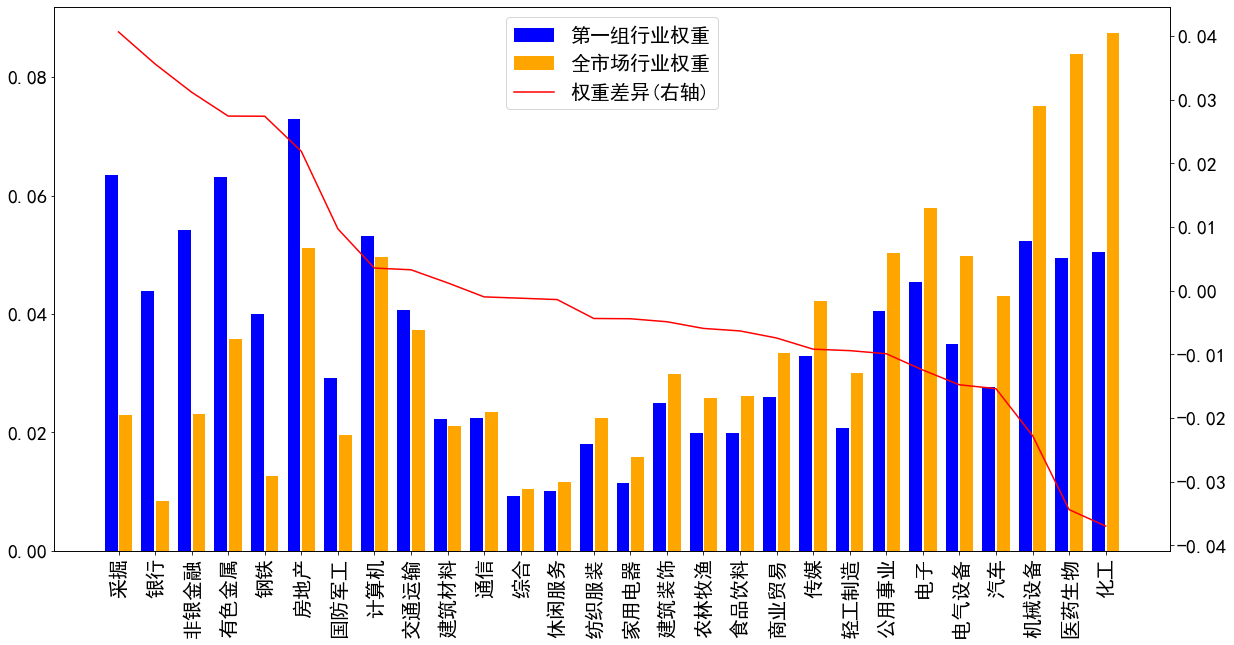

In [36]:
fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
xt = list(range(len(ind_plot)))

b1 = ax.bar([i-0.2 for i in xt],ind_plot["第一组行业权重"],color="blue",width=0.35)
b2 = ax.bar([i+0.2 for i in xt],ind_plot["全市场行业权重"],color="orange",width=0.35)
plt.yticks(fontsize=20)
plt.xticks(xt,ind_plot.index,fontsize=20,rotation=90)
ax1 = ax.twinx()
l, = ax1.plot(xt,ind_plot["DIFF"],"r-")
plt.yticks(fontsize=20)

plt.legend([b1,b2,l],["第一组行业权重","全市场行业权重","权重差异(右轴)"],loc="upper center",fontsize=20)

# Rank_IC

In [37]:
ic = pd.DataFrame(ic_list,columns=["Rank_IC","p_value","Rank_IC(mv)"],index=datelist)
IC_mean = ic["Rank_IC"].mean()
IC_std = ic["Rank_IC"].std()
pvalue_mean = ic["p_value"].mean()
IR = IC_mean / IC_std
IC_corr = ss.spearmanr(ic["Rank_IC"],ic["Rank_IC(mv)"])[0]
pos_p = len(ic.query('Rank_IC>=0 and p_value<=0.01')) / len(ic.query('Rank_IC>=0'))
neg_p = len(ic.query('Rank_IC<0 and p_value<=0.01')) / len(ic.query('Rank_IC<0'))
mdf = pd.DataFrame([IC_mean,pvalue_mean,IR,pos_p,neg_p,IC_corr])
mdf.columns = ["Metric"]
mdf.index = ["IC均值","P-value均值","ICIR","正显著比例","负显著比例","与市值IC的相关性"]
mdf.T

,IC均值,P-value均值,ICIR,正显著比例,负显著比例,与市值IC的相关性
Metric,0.072284,0.106623,0.797695,0.691667,0.305556,0.377206


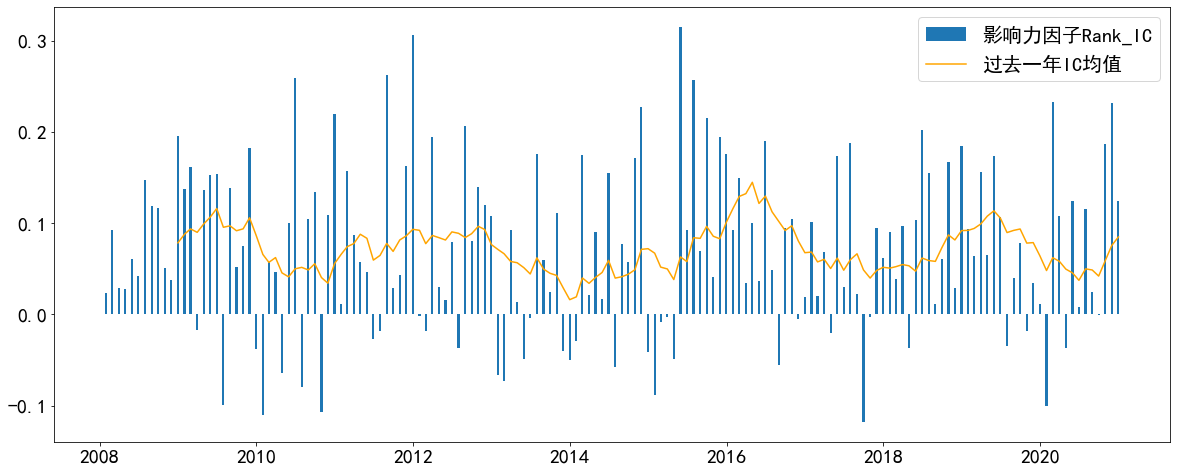

In [38]:
ic["roll12"] = ic["Rank_IC"].rolling(12).mean()

fig = plt.figure(figsize=(20,8))
xdate = [datetime.strptime(x,"%Y-%m-%d") for x in ic.index.tolist()]
b = plt.bar(xdate,ic["Rank_IC"],width=10)
l, = plt.plot(xdate,ic["roll12"],"orange")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend([b,l],["影响力因子Rank_IC","过去一年IC均值"],fontsize=20)

# 自相关系数

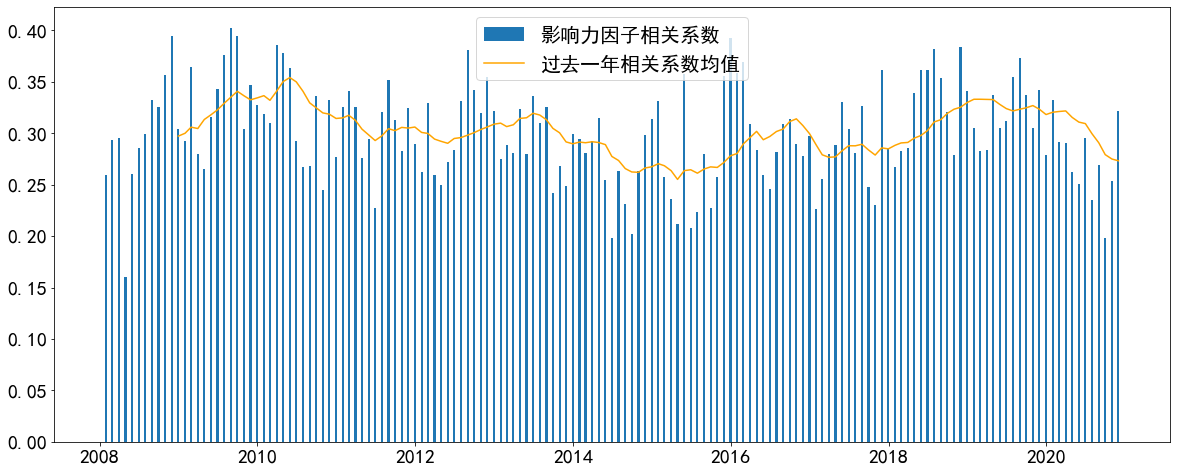

In [39]:
corrdf = pd.DataFrame(corr_list,columns=["corr"],index=datelist)
corrdf = corrdf.dropna()
corrdf["roll12"] = corrdf["corr"].rolling(12).mean()

fig = plt.figure(figsize=(20,8))
xdate = [datetime.strptime(x,"%Y-%m-%d") for x in corrdf.index.tolist()]
b = plt.bar(xdate,corrdf["corr"],width=10)
l, = plt.plot(xdate,corrdf["roll12"],"orange")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend([b,l],["影响力因子相关系数","过去一年相关系数均值"],fontsize=20)

In [40]:
corrdf["corr"].describe()

count    155.000000
mean       0.300252
std        0.046200
min        0.160331
25%        0.268531
50%        0.295552
75%        0.331485
max        0.402666
Name: corr, dtype: float64

# 与风格因子的关系

In [41]:
fdf = pd.DataFrame()
for i in fac_stats:
    i = i.unstack()
    fdf = pd.concat([fdf,i],axis=1)
fdf = fdf.mean(axis=1)
fdf = pd.DataFrame(fdf)
fdf["index"] = fdf.index
fdf["fac"] = fdf["index"].apply(lambda x:x[0])
fdf["group"] = fdf["index"].apply(lambda x:x[1])
fdf = fdf.set_index(["fac","group"])
fdf = fdf.drop(labels=["index"],axis=1)
fdf = fdf[0].unstack()
fdf.columns.name = ""
fdf.index.name = ""
fdf = fdf.T
fdf.index = ["Group"+str(i+1) for i in fdf.index]
fdf

,lnmv,rev,tr,vol
Group1,22.632114,0.973864,0.019090,0.025980
Group2,22.192164,0.977349,0.021683,0.026230
Group3,22.074548,0.983366,0.024238,0.027113
Group4,22.022009,0.989198,0.025899,0.027772
Group5,21.977881,0.996198,0.027798,0.028472
Group6,21.951165,1.005903,0.030033,0.029312
Group7,21.908761,1.016577,0.032517,0.030275
Group8,21.886640,1.028655,0.035673,0.031217
Group9,21.844603,1.046240,0.039673,0.032528
Group10,21.788694,1.081150,0.049065,0.035818


# Fama MacBeth 回归

In [42]:
from linearmodels import FamaMacBeth
import statsmodels.api as sm
rdf = pdata.copy()
rdf["date"] = [datetime.strptime(x[1],"%Y-%m-%d") for x in rdf.index.tolist()]
#rdf = rdf.dropna(subset=["return"],axis=0)
rdf["code"] = [x[0] for x in rdf.index.tolist()]
rdf = rdf.set_index(["code","date"])

In [43]:
fac = ["lnmv","vol","rev","tr"]

for f in fac:
    exog = sm.add_constant(rdf[f])
    fm = FamaMacBeth(rdf['P'], exog)
    sfm = fm.fit()
    print(sfm)
    print('-----------------------------------------------------------------------------')

                             FamaMacBeth Estimation Summary                            
Dep. Variable:                             P   R-squared:                       -0.0013
Estimator:                       FamaMacBeth   R-squared (Between):              0.1540
No. Observations:                     373171   R-squared (Within):              -0.0395
Date:                       Thu, Jun 24 2021   R-squared (Overall):             -0.0013
Time:                               08:16:14   Log-likelihood                -6.325e+05
Cov. Estimator:    Fama-MacBeth Standard Cov                                           
                                               F-statistic:                     -473.09
Entities:                               3734   P-value                           1.0000
Avg Obs:                              99.939   Distribution:                F(1,373169)
Min Obs:                              2.0000                                           
Max Obs:                        

In [44]:
exog = sm.add_constant(rdf[fac])
fm = FamaMacBeth(rdf['P'], exog)
sfm = fm.fit()
print(sfm)

                             FamaMacBeth Estimation Summary                            
Dep. Variable:                             P   R-squared:                        0.0128
Estimator:                       FamaMacBeth   R-squared (Between):              0.3247
No. Observations:                     373171   R-squared (Within):              -0.0318
Date:                       Thu, Jun 24 2021   R-squared (Overall):              0.0128
Time:                               08:16:16   Log-likelihood                -6.299e+05
Cov. Estimator:    Fama-MacBeth Standard Cov                                           
                                               F-statistic:                      1209.3
Entities:                               3734   P-value                           0.0000
Avg Obs:                              99.939   Distribution:                F(4,373166)
Min Obs:                              2.0000                                           
Max Obs:                        

# 中性化后的因子表现

# 中性化因子分组回测

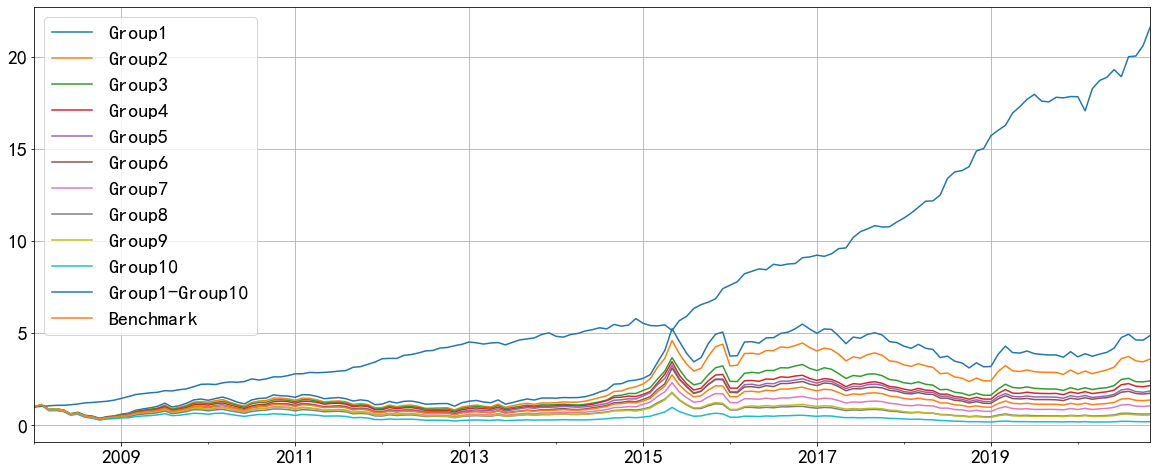

In [45]:
cost0 = 0.003 #买入时交易成本
cost1 = 0.003 #卖出时交易成本
#全市场等权组合
benchmark = [((1-cost0)*(x[1]+1)*(1-cost1)-1) for x in neu_back_test]
benchmark = pd.DataFrame(benchmark,index=datelist)

group_return = pd.DataFrame()
for i in neu_back_test:
    group_return = pd.concat([group_return,i[0]],axis=1)
group_return.columns = datelist
group_return.index = ["Group"+str(i+1) for i in group_return.index]
group_return = group_return.T
def costfun(x):
    return (1-cost0)*(x+1)*(1-cost1)-1
group_return = group_return.applymap(lambda x:costfun(x))

group_return["Group1-Group10"] = group_return["Group1"] - group_return["Group10"]
group_return["Benchmark"] = benchmark
group_return = group_return.shift(1)
group_return = group_return[0:-1]
group_return = group_return.fillna(0)

xdate = [datetime.strptime(x,"%Y-%m-%d") for x in group_return.index]

return_plot1 = group_return + 1
return_plot1.index = xdate
return_plot1 = return_plot1.cumprod()
return_plot1.plot(figsize=(20,8),fontsize=20,grid=True)
plt.legend(fontsize=20)

In [46]:
last = return_plot1.iloc[len(return_plot1)-1,:]
year_r = (last[:10] - 1)*(252 / ((2020-2008+1)*252 - 22))
excess_r = (last[:10] - last["Benchmark"])*(252 / ((2020-2008+1)*252 - 22))
year_r.name = "年化收益"
excess_r.name = "超额年化"

gr = group_return.iloc[:,:10].copy()
pr1 = []
for i in gr.columns:
    gr[i] = gr[i] - group_return["Benchmark"]
    winp = list(gr[i]>0).count(True) / len(gr)
    pcr = gr[gr[i]>0][i].mean() / abs(gr[gr[i]<=0][i].mean())
    
    y = group_return[i].values.reshape(-1,1)
    x = group_return["Benchmark"].values.reshape(-1,1)
    information_ratio = cal_ir(x,y)
    pr1.append([winp,pcr,information_ratio])
    
pr1 = pd.DataFrame(pr1,index=year_r.index,columns=["超额胜率","超额盈亏比","信息比率"])

pdf1 = pd.concat([year_r,excess_r,pr1],axis=1)
pdf1

,年化收益,超额年化,超额胜率,超额盈亏比,信息比率
Group1,0.300207,0.271210,0.761290,1.565606,2.007957
Group2,0.201994,0.172997,0.683871,2.040966,1.852785
Group3,0.109601,0.080604,0.651613,1.500370,1.263841
Group4,0.089815,0.060818,0.612903,1.474378,1.090884
Group5,0.066877,0.037880,0.651613,1.089716,0.915861
Group6,0.057237,0.028240,0.561290,1.295369,0.556244
Group7,0.004410,-0.024587,0.400000,0.900152,-0.642092
Group8,-0.029838,-0.058835,0.283871,0.568585,-1.807174
Group9,-0.033982,-0.062979,0.309677,0.630520,-1.756751
Group10,-0.062313,-0.091310,0.212903,0.491115,-2.664427


In [47]:
#获取同期300和500数据
e_index = pd.read_excel(file+"e_index.xls")
e_index = e_index.set_index(["date"])
e_index.index = [datetime.strftime(x,"%Y-%m-%d") for x in e_index.index]
e_index = e_index.shift(1)
e_index = e_index.fillna(0)

group_return["sh.000300"] = e_index["sh.000300"]
group_return["sh.000905"] = e_index["sh.000905"]
adf = []
odf = []

for i in range(2020-2008+1):
    temp = group_return.iloc[i*12:(i+1)*12,:]
    
    cptemp = temp["Group1"]+1
    cptemp = cptemp.cumprod()
    yr = list(cptemp)[-1] - 1

    maxdrawdown = cptemp / cptemp.cummax() - 1
    maxdrawdown = abs(maxdrawdown.min())
    abs_winp = list(temp["Group1"]>0).count(True) / len(temp)
    adf.append([i+2008,yr,maxdrawdown,abs_winp])
    
    for bm in ["Benchmark","sh.000300","sh.000905"]:
        otemp = temp["Group1"] - temp[bm]
        cpo = otemp + 1
        cpo = cpo.cumprod()
        oyr = list(cpo)[-1] - 1
        
        omaxdrawdown = cpo / cpo.cummax() - 1
        omaxdrawdown = abs(omaxdrawdown.min())
        opo_winp = list(otemp>0).count(True) / len(otemp)
        
        x = temp[bm].values.reshape(-1,1)
        y = temp["Group1"].values.reshape(-1,1)
        
        ir = cal_ir(x,y)
        
        odf.append([i+2008,bm,oyr,omaxdrawdown,opo_winp,ir])

adf = pd.DataFrame(adf,columns=["年份","年度收益","最大回撤","绝对胜率"])
adf

,年份,年度收益,最大回撤,绝对胜率
0,2008,-0.488029,0.658713,0.416667
1,2009,1.786752,0.171644,0.916667
2,2010,0.114413,0.241725,0.500000
3,2011,-0.295395,0.326208,0.333333
4,2012,0.094009,0.208932,0.666667
5,2013,0.210043,0.167469,0.666667
6,2014,0.655284,0.005427,0.833333
7,2015,1.061139,0.343086,0.750000
8,2016,0.032043,0.049040,0.750000
9,2017,-0.139966,0.153265,0.333333


In [48]:
odf = pd.DataFrame(odf,columns=["年份","基准","相对年度收益","相对最大回撤","相对胜率","信息比率"])
odf["基准"] = odf["基准"].replace(["Benchmark"],["全市场等权"])
odf.query('基准=="全市场等权"')

,年份,基准,相对年度收益,相对最大回撤,相对胜率,信息比率
0,2008,全市场等权,0.139806,0.002994,0.833333,4.275685
3,2009,全市场等权,0.228369,0.000000,1.000000,6.772727
6,2010,全市场等权,0.037826,0.024761,0.500000,0.866296
9,2011,全市场等权,0.114040,0.002134,0.666667,3.098337
12,2012,全市场等权,0.114984,0.005232,0.833333,3.071994
15,2013,全市场等权,0.014480,0.049995,0.666667,0.434172
18,2014,全市场等权,0.102023,0.005906,0.666667,1.716873
21,2015,全市场等权,0.142951,0.024381,0.750000,1.713742
24,2016,全市场等权,0.124143,0.005215,0.833333,4.417024
27,2017,全市场等权,0.083125,0.000000,0.916667,3.627214


In [53]:
odf.query('基准=="sh.000300"')

,年份,基准,相对年度收益,相对最大回撤,相对胜率,信息比率
1,2008,sh.000300,0.345131,0.095585,0.500000,1.735147
4,2009,sh.000300,0.411457,0.075520,0.833333,2.906412
7,2010,sh.000300,0.268364,0.036554,0.666667,2.329894
10,2011,sh.000300,-0.052191,0.090433,0.583333,-0.392488
13,2012,sh.000300,0.019389,0.077907,0.500000,0.215678
16,2013,sh.000300,0.319693,0.023318,0.750000,2.873963
19,2014,sh.000300,0.020558,0.288832,0.666667,0.431226
22,2015,sh.000300,1.002154,0.053772,0.750000,2.692337
25,2016,sh.000300,0.183611,0.021823,0.666667,1.731756
28,2017,sh.000300,-0.296837,0.266918,0.333333,-2.235885


In [54]:
odf.query('基准=="sh.000905"')

,年份,基准,相对年度收益,相对最大回撤,相对胜率,信息比率
2,2008,sh.000905,0.240252,0.038124,0.666667,2.556949
5,2009,sh.000905,0.227609,0.006042,0.750000,4.716759
8,2010,sh.000905,0.017132,0.048485,0.583333,0.224984
11,2011,sh.000905,0.058938,0.021671,0.666667,1.127499
14,2012,sh.000905,0.091148,0.013660,0.750000,2.248867
17,2013,sh.000905,0.038492,0.056689,0.583333,0.768494
20,2014,sh.000905,0.198492,0.003557,0.833333,2.846744
23,2015,sh.000905,0.475345,0.033428,0.666667,2.474398
26,2016,sh.000905,0.250917,0.011796,0.750000,3.790612
29,2017,sh.000905,-0.133335,0.111390,0.333333,-2.378793


# 中性化因子市值分布

(array([  0.,  50., 100., 150., 200., 250., 300.]),
 <a list of 7 Text major ticklabel objects>)

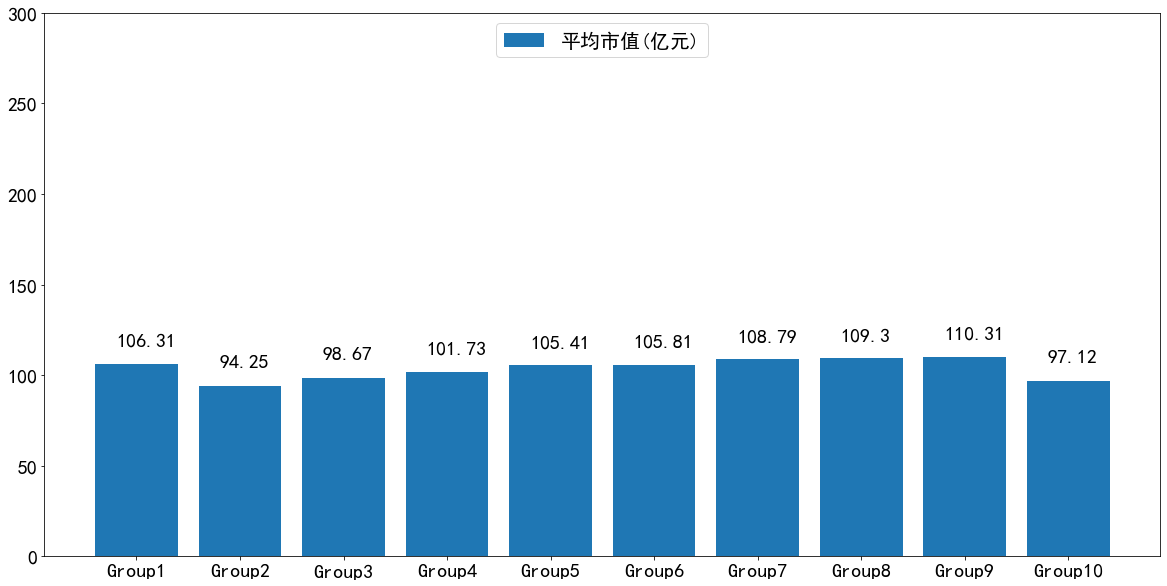

In [49]:
mv_plot1 = []
for i in neu_mv_stats:
    mv_plot1.append(i[4])
mv_plot1 = pd.DataFrame(mv_plot1)
mv_plot1 = mv_plot1.mean(axis=0)
mv_plot1 = mv_plot1 / 1e+8
mv_plot1.index = ["Group"+str(x) for x in range(1,11)]
mv_plot1 = mv_plot1.apply(lambda x:round(x,2))

fig = plt.figure(figsize=(20,10))
b = plt.bar(mv_plot1.index,mv_plot1.values)
plt.legend([b],["平均市值(亿元)"],loc="upper center",fontsize=20)
for i in range(len(mv_plot1.index)):
    plt.text(i-0.2,mv_plot1[i]+10,mv_plot1[i],fontsize=20)
    
plt.ylim(0,300)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

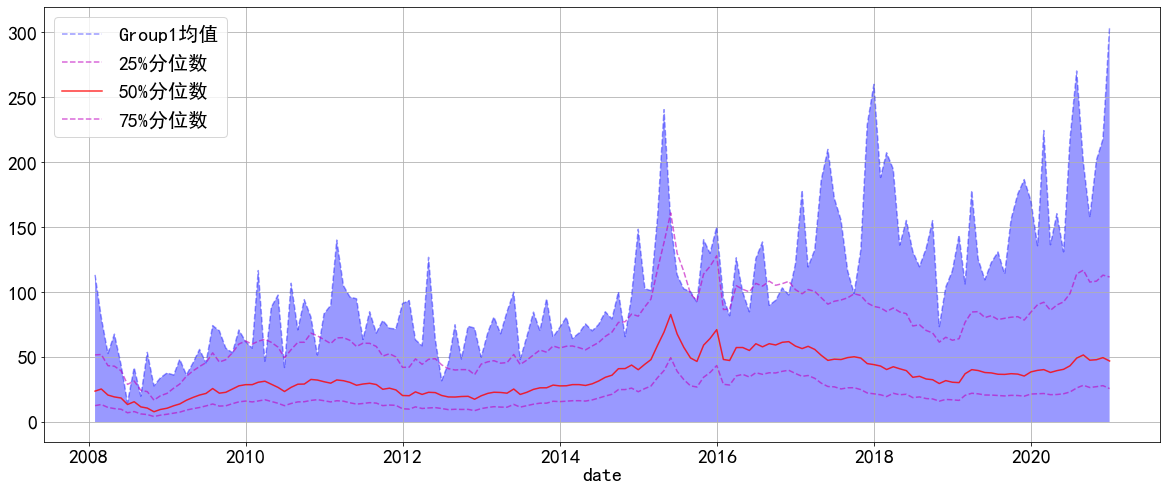

In [50]:
mv_plot2 = []
for i in neu_mv_stats:
    mv_plot2.append(i[:4])
mv_plot2 = pd.DataFrame(mv_plot2,columns=["25%","50%","75%","Group1均值"],index=datelist)
mv_plot2 = mv_plot2/1e+8

index = mv_plot2.loc[:,"Group1均值"]
l25 = mv_plot2.loc[:,"25%"]
l50 = mv_plot2.loc[:,"50%"]
l75 = mv_plot2.loc[:,"75%"]
xdate = [datetime.strptime(x,"%Y-%m-%d") for x in mv_plot2.index.tolist()]

fig = plt.figure(figsize=(20,8))
ax = plt.subplot(111)
l1, = ax.plot(xdate,index,"b--",alpha=0.4)
ax.fill_between(xdate,0,index,facecolor='blue', alpha=0.4)

ax.set_xlabel("date",fontsize=20)

l25, = ax.plot(xdate,l25,"m--",alpha=0.6)
l50, = ax.plot(xdate,l50,"r",alpha=0.8)
l75, = ax.plot(xdate,l75,"m--",alpha=0.6)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.grid(True)
plt.legend([l1,l25,l50,l75],["Group1均值","25%分位数","50%分位数","75%分位数"],fontsize=20)

# 中性化因子的IC

In [51]:
ic = pd.DataFrame(neu_ic_list,columns=["Rank_IC","p_value","Rank_IC(mv)"],index=datelist)
IC_mean = ic["Rank_IC"].mean()
IC_std = ic["Rank_IC"].std()
pvalue_mean = ic["p_value"].mean()
IR = IC_mean / IC_std
IC_corr = ss.spearmanr(ic["Rank_IC"],ic["Rank_IC(mv)"])[0]
pos_p = len(ic.query('Rank_IC>=0 and p_value<=0.01')) / len(ic.query('Rank_IC>=0'))
neg_p = len(ic.query('Rank_IC<0 and p_value<=0.01')) / len(ic.query('Rank_IC<0'))
mdf = pd.DataFrame([IC_mean,pvalue_mean,IR,pos_p,neg_p,IC_corr])
mdf.columns = ["Metric"]
mdf.index = ["IC均值","P-value均值","ICIR","正显著比例","负显著比例","与市值IC的相关性"]
mdf.T

,IC均值,P-value均值,ICIR,正显著比例,负显著比例,与市值IC的相关性
Metric,0.077695,0.099499,1.104642,0.718519,0.190476,-0.006499


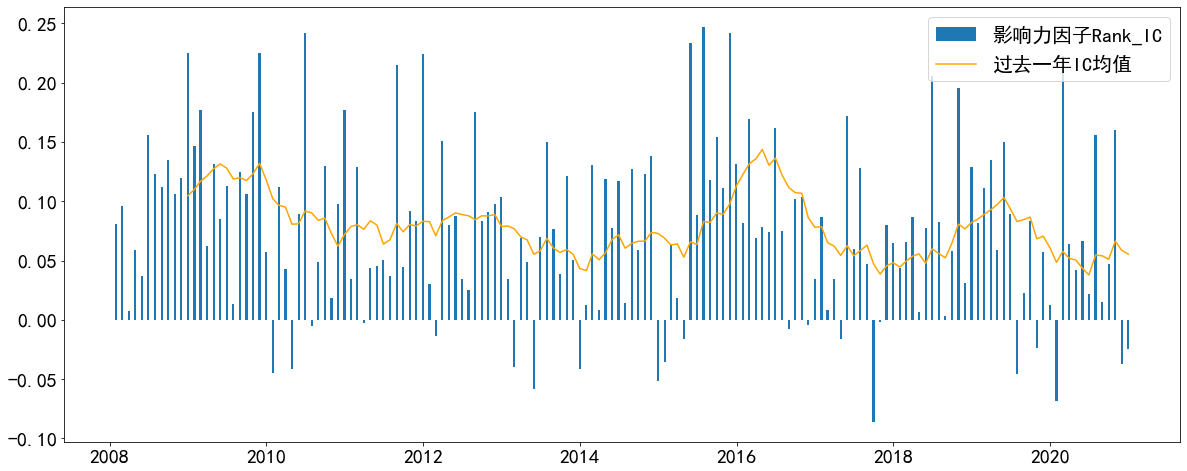

In [52]:
ic["roll12"] = ic["Rank_IC"].rolling(12).mean()

fig = plt.figure(figsize=(20,8))
xdate = [datetime.strptime(x,"%Y-%m-%d") for x in ic.index.tolist()]
b = plt.bar(xdate,ic["Rank_IC"],width=10)
l, = plt.plot(xdate,ic["roll12"],"orange")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend([b,l],["影响力因子Rank_IC","过去一年IC均值"],fontsize=20)